In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import ast
import matplotlib.pyplot as plt
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')


In [2]:
# Load the dataset

data = pd.read_csv('dr.csv',header=None)

first_value = data.columns[0]
data.columns = [first_value]
data = pd.DataFrame(data[first_value].to_list(), columns=['Price'])

print(data.head())
data.shape

   Price
0  25.56
1  26.00
2  26.53
3  25.85
4  25.87


(9196, 1)

In [3]:
# Preprocess the data
def preprocess_data(data, window_size=12):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

window_size=12
X, y = preprocess_data(scaled_data, window_size)


In [4]:
# Preprocess the data
def preprocess_data(data, window_size=12):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

window_size=12
X, y = preprocess_data(scaled_data, window_size)


In [5]:
# Split data into train, validation, and test sets
train_size = int(len(X) * 0.7)
val_size = int(len(X) * 0.15)
test_size = len(X) - train_size - val_size

X_train, X_val, X_test = X[:train_size], X[train_size:train_size+val_size], X[train_size+val_size:]
y_train, y_val, y_test = y[:train_size], y[train_size:train_size+val_size], y[train_size+val_size:]

window_size = X_train.shape[1]  # Assuming X_train has shape (num_samples, window_size, num_features)
input_shape = (window_size, X_train.shape[2])


In [6]:
X_test.shape

(1379, 12, 1)

In [7]:
input_shape

(12, 1)

In [8]:
def lube_loss(y_true, y_pred):
    lower_bound = y_pred[:, 0]
    upper_bound = y_pred[:, 1]
    q = 0.05  # Quantile value
   
    # Pinball loss for the lower bound
    lower_loss = tf.reduce_mean(tf.maximum(0.0, lower_bound - y_true) * q)
    
    # Pinball loss for the upper bound
    upper_loss = tf.reduce_mean(tf.maximum(0.0, y_true - upper_bound) * (1 - q))
    
    # PICP (Prediction Interval Coverage Probability)
    picp = tf.reduce_mean(tf.cast((y_true >= lower_bound) & (y_true <= upper_bound), tf.float32))
    
     # PINAW (Prediction Interval Normalized Average Width) penalty
    interval_width = upper_bound - lower_bound
    max_true = tf.reduce_max(y_true)
    min_true = tf.reduce_min(y_true)
    pinaw = tf.reduce_mean(interval_width) / (max_true - min_true)
    
    return lower_loss + upper_loss + tf.square(tf.maximum(0.9 - picp, 0.0))


In [9]:
def create_lstm_model(input_shape, neurons1=64, neurons2=32, dropout_rate=0.2, learning_rate=0.001):
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(neurons1, activation='elu', kernel_initializer='glorot_uniform', input_shape=input_shape, return_sequences=True, dropout=dropout_rate),
        tf.keras.layers.LSTM(neurons2, activation='sigmoid', kernel_initializer='glorot_uniform', dropout=dropout_rate),
        tf.keras.layers.Dense(2, activation='linear')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss=lube_loss)
    return model

def create_cnn_model(input_shape, neurons1=32, neurons2=16, dropout_rate=0.3, learning_rate=0.0001):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv1D(neurons1, kernel_size=3, activation='elu', kernel_initializer='he_normal', input_shape=input_shape),
        tf.keras.layers.Conv1D(neurons2, kernel_size=3, activation='sigmoid', kernel_initializer='glorot_normal'),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(2, activation='linear')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss=lube_loss)
    return model

def create_gru_model(input_shape, neurons1=64, neurons2=32, dropout_rate=0.1, learning_rate=0.0005):
    model = tf.keras.Sequential([
        tf.keras.layers.GRU(neurons1, activation='elu', kernel_initializer='glorot_uniform', input_shape=input_shape, return_sequences=True, dropout=dropout_rate),
        tf.keras.layers.GRU(neurons2, activation='tanh', kernel_initializer='he_normal', dropout=dropout_rate),
        tf.keras.layers.Dense(2, activation='linear')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss=lube_loss)
    return model

def create_bilstm_model(input_shape, neurons1=128, neurons2=64, dropout_rate=0.25, learning_rate=0.001):
    model = tf.keras.Sequential([
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(neurons1, activation='tanh', kernel_initializer='glorot_normal', input_shape=input_shape, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(neurons2, activation='elu', kernel_initializer='he_uniform', dropout=dropout_rate)),
        tf.keras.layers.Dense(2, activation='linear')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss=lube_loss)
    return model


In [10]:
def calculate_metrics(y_test_inv, y_pred_inv):
    PICP = np.mean((y_pred_inv[:, 0] <= y_test_inv) & (y_test_inv <= y_pred_inv[:, 1])) * 100
    PINAW = np.mean(y_pred_inv[:, 1] - y_pred_inv[:, 0]) / (np.max(y_test_inv) - np.min(y_test_inv))
    return PICP, PINAW, None  # Returning a tuple of metrics


In [11]:
%%capture
# Define confidence levels
confidence_levels = [0.9, 0.8, 0.7, 0.6]

# Define number of runs
num_runs = 20

# Define models
models = {
    "LSTM": create_lstm_model,
    "CNN": create_cnn_model,
    "GRU": create_gru_model,
    "BiLSTM": create_bilstm_model
}

# Initialize dictionary to hold results
overall_results = {}

for confidence_level in confidence_levels:
    results = {}
    for model_name, create_model_func in models.items():
        model_results = []
        lower_bound = []
        upper_bound = []
        for _ in range(num_runs):
            model = create_model_func(input_shape)
            model.fit(X_train, y_train, epochs=50, batch_size=8, validation_data=(X_val, y_val), verbose=0)
            y_pred = model.predict(X_test)

            # Inverse transform to get original price scale
            y_test_inv = scaler.inverse_transform(y_test)
            y_pred_inv = scaler.inverse_transform(y_pred)
            
            # Calculate metrics
            PICP, PINAW, _ = calculate_metrics(y_test_inv, y_pred_inv)
            
            # Calculate ACE and AWE
            desired_picp = confidence_level * 100
            ACE = np.abs(PICP - desired_picp)
            AWE = np.abs(np.mean(y_pred_inv[:, 1] - y_pred_inv[:, 0]) - (np.max(y_test_inv) - np.min(y_test_inv)))

            model_results.append((PICP, PINAW, ACE, AWE))
            lower_bound.append(y_pred_inv[:, 0])  # Store predicted values
            upper_bound.append(y_pred_inv[:, 1])

        results[model_name] = {
            'metrics': model_results,
            'lower_bounds': np.array(lower_bound),
            'upper_bounds': np.array(upper_bound)
        }

    overall_results[confidence_level] = results

# Flatten the results for DataFrame conversion
flattened_results = []

for confidence_level, results_dict in overall_results.items():
    for model_name, model_data in results_dict.items():
        for i, metrics in enumerate(model_data['metrics']):
            flattened_results.append({
                'Confidence Level': confidence_level,
                'Model': model_name,
                'PICP': metrics[0],
                'PINAW': metrics[1],
                'ACE': metrics[2],
                'AWE': metrics[3],
                'Lower Bounds': model_data['lower_bounds'][i].tolist(),
                'Upper Bounds': model_data['upper_bounds'][i].tolist()
            })

# Convert the flattened results into a DataFrame
overall_results_df = pd.DataFrame(flattened_results)

# Save the DataFrame to a CSV file
overall_results_df.to_csv("dr_results.csv", index=False)

print("Overall results saved to 'dr_results.csv'.")


In [12]:
# Load the results
all_results_df = pd.read_csv("dr_results.csv")

# Convert 'Lower Bounds' and 'Upper Bounds' from strings to lists
all_results_df['Lower Bounds'] = all_results_df['Lower Bounds'].apply(ast.literal_eval)
all_results_df['Upper Bounds'] = all_results_df['Upper Bounds'].apply(ast.literal_eval)

# Aggregate results and calculate average metrics
grouped = all_results_df.groupby(['Confidence Level', 'Model'])
avg_results = []

for name, group in grouped:
    avg_picp = group['PICP'].mean()
    avg_pinaw = group['PINAW'].mean()
    avg_ace = group['ACE'].mean()
    avg_awe = group['AWE'].mean()
    std_picp = group['PICP'].std()
    std_pinaw = group['PINAW'].std()
    std_ace = group['ACE'].std()
    std_awe = group['AWE'].std()
    
    lower_bounds = group['Lower Bounds'].apply(np.array).values
    upper_bounds = group['Upper Bounds'].apply(np.array).values
    
    lower_bounds_avg = np.mean(np.vstack(lower_bounds), axis=0).tolist()
    upper_bounds_avg = np.mean(np.vstack(upper_bounds), axis=0).tolist()
    
    avg_results.append({
        'Confidence Level': name[0],
        'Model': name[1],
        'Avg PICP': avg_picp,
        'Avg PINAW': avg_pinaw,
        'Avg ACE': avg_ace,
        'Avg AWE': avg_awe,
        'Lower Bounds': lower_bounds_avg,
        'Upper Bounds': upper_bounds_avg,
        'Std PICP': std_picp,
        'Std PINAW': std_pinaw,
        'Std ACE': std_ace,
        'Std AWE': std_awe
    })

# Save the averaged results to a CSV file
avg_results_df = pd.DataFrame(avg_results)
avg_results_df.to_csv('avg_dr_results.csv', index=False)
print("Results are saved to avg_dr_results.csv")


Results are saved to avg_dr_results.csv


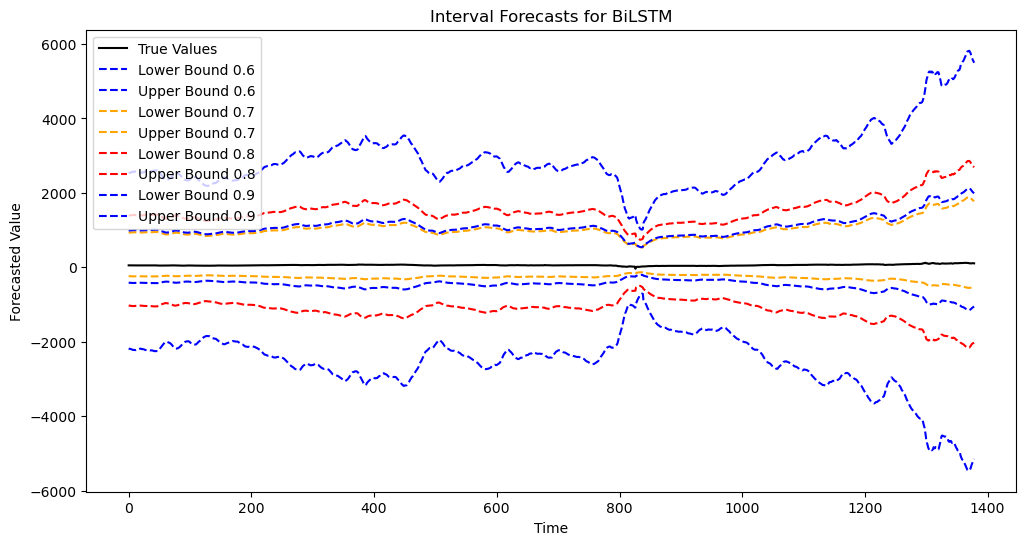

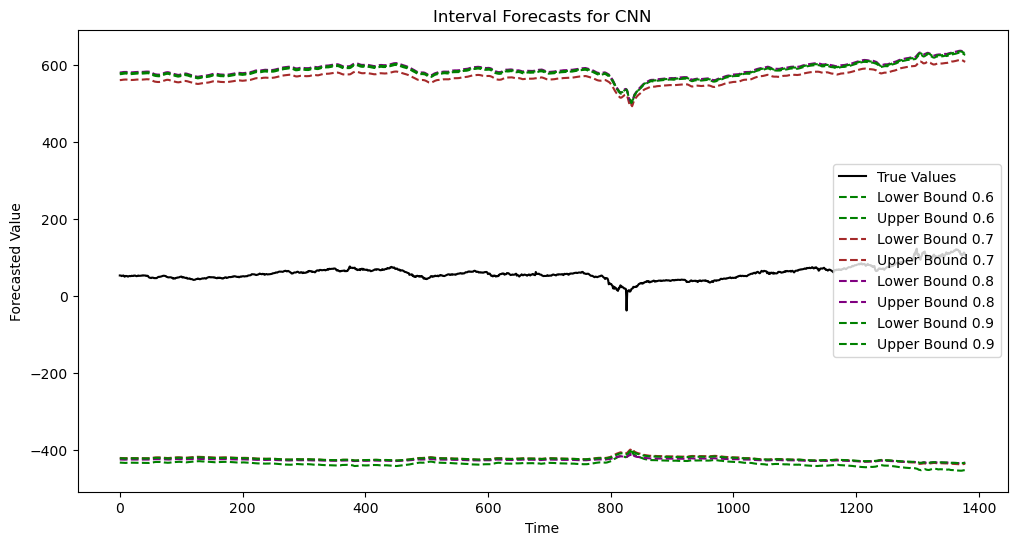

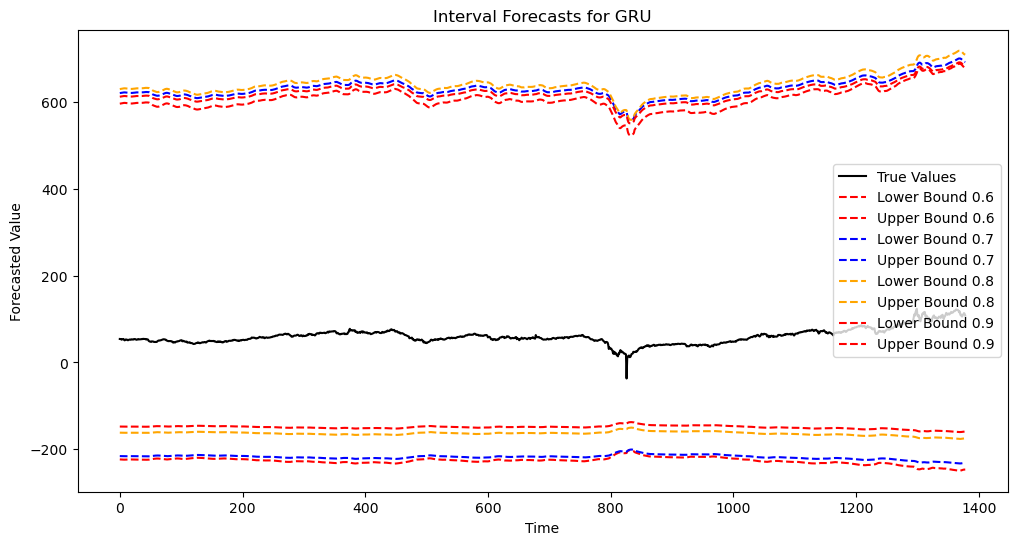

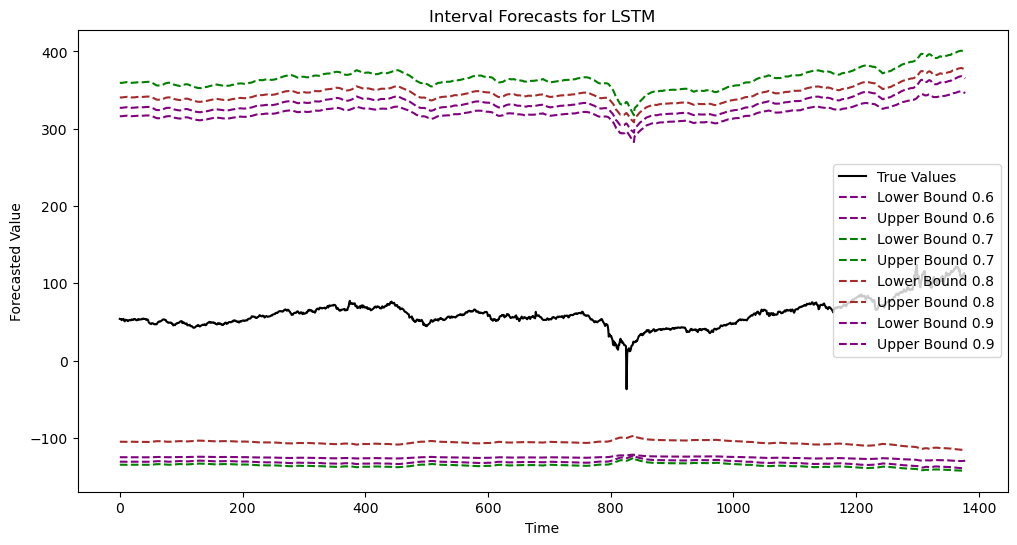

In [13]:
import matplotlib.pyplot as plt
import ast
import pandas as pd
import numpy as np

# Load the averaged results from the CSV file
averaged_df = pd.read_csv("avg_dr_results.csv")

# Convert 'Lower Bounds' and 'Upper Bounds' from strings to lists
averaged_df['Lower Bounds'] = averaged_df['Lower Bounds'].apply(ast.literal_eval)
averaged_df['Upper Bounds'] = averaged_df['Upper Bounds'].apply(ast.literal_eval)

# Load y_test values

y_test_inv = scaler.inverse_transform(y_test)

# Plot interval forecasts for each model along with true y_test values
models = averaged_df['Model'].unique()

colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown']  # Add more colors if needed

for model in models:
    model_data = averaged_df[averaged_df['Model'] == model]
    
    plt.figure(figsize=(12, 6))
    
    # Plot the true values of y_test
    plt.plot(y_test_inv, color='black', label='True Values', linewidth=1.5)
    
    for i, row in model_data.iterrows():
        confidence_level = row['Confidence Level']
        lower_bounds = row['Lower Bounds']
        upper_bounds = row['Upper Bounds']
        
        # Plot lower bound
        plt.plot(lower_bounds, linestyle='--', color=colors[i % len(colors)], label=f'Lower Bound {confidence_level}')
        
        # Plot upper bound
        plt.plot(upper_bounds, linestyle='--', color=colors[i % len(colors)], label=f'Upper Bound {confidence_level}')
    
    plt.title(f'Interval Forecasts for {model}')
    plt.xlabel('Time')
    plt.ylabel('Forecasted Value')
    plt.legend(loc='best')
    plt.show()
